# Detección de Anomalías

Vamos a usar una base de datos generada y detectaremos anomalías en las mismas. 

Para eso, vamos a utilizar un método basado en distancias y el Local Oulier Factor, basado en densidad.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
from matplotlib.colors import ListedColormap
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
np.random.seed(42)

## Generación

In [25]:
# Generamos datos normales
X_datos = 0.3 * np.random.randn(100, 2)
X_datos = np.r_[X_datos + 2, X_datos - 2]
# Generamos anomalías
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
# Unimos los dos tipos en una base de datos única
X = np.r_[X_datos, X_outliers]
df = pd.DataFrame(X, columns=['att1', 'att2'])

# Cantidad de anomalías
n_outliers = len(X_outliers)
# Cuales son normales y cuales no.
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [26]:
df.head()

,att1,att2
0,2.149014,1.958521
1,2.194307,2.456909
2,1.929754,1.929759
3,2.473764,2.230230
4,1.859158,2.162768


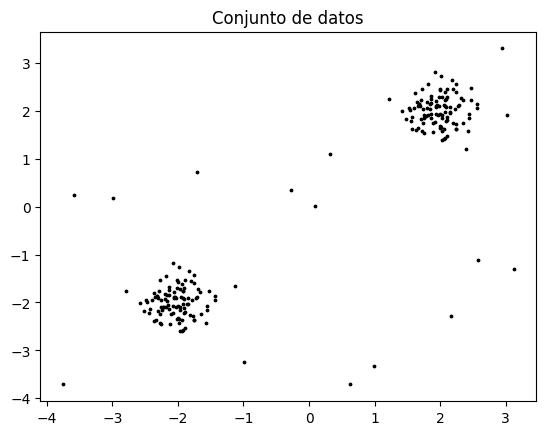

In [27]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(df['att1'], df['att2'], color="k", s=3.0, label="Puntos")
plt.title("Conjunto de datos")
plt.show()

Como vemos, tenemos dos regiones de datos normales, y multiples puntos dispersos que pueden ser considerados anomalías. 

Vamos a detectarlos usando K-means.

Para eso, primero agrupamos, y luego calculamos la distancia de cada punto a su centroide.

In [28]:
kmeans_model = KMeans(n_clusters=2)

df_grouped = df.copy()
df_grouped['cluster'] = kmeans_model.fit_predict(df)
df_grouped.head()


,att1,att2,cluster
0,2.149014,1.958521,1
1,2.194307,2.456909,1
2,1.929754,1.929759,1
3,2.473764,2.230230,1
4,1.859158,2.162768,1


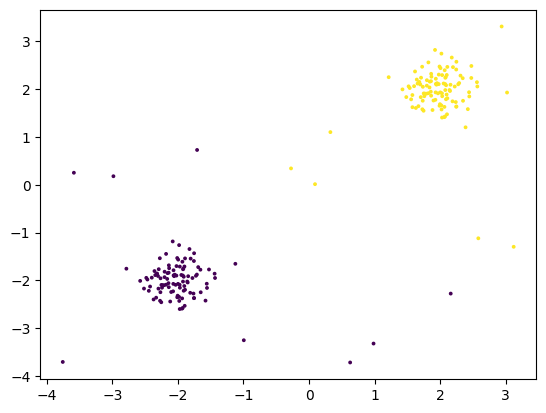

In [29]:
plt.scatter(df_grouped['att1'], df_grouped['att2'], c=df_grouped['cluster'], s=3.0, label="Puntos")

Vemos que cada punto está asignado a un cluster.

Para detectar las anomalías, nos fijaremos en las distancias de cada elemento al centroide del cluster al que pertenecen.

Calculemos ahora la distancia de cada punto a su centroide.

In [30]:
# Vemos cuales son los centroides.
centroides = kmeans_model.cluster_centers_
print("Centroides: ")
print(centroides)
# Calculamos una nueva columna, igual a la distancia de cada elemento a su centroide más cercano.
df_grouped['dist_to_nearest'] = [min(distances) for distances in euclidean_distances(df, centroides)]
df_grouped.head()
    

Centroides: 
[[-1.9619335  -1.97915247]
 [ 1.94939819  1.91853864]]


,att1,att2,cluster,dist_to_nearest
0,2.149014,1.958521,1,0.203581
1,2.194307,2.456909,1,0.591458
2,1.929754,1.929759,1,0.022623
3,2.473764,2.230230,1,0.610009
4,1.859158,2.162768,1,0.260368


Ahora que tenemos la distancia de cada elemento a su centroide, vamos a plotear la distribución de estas distancias, para ver que es lo que esperaríamos obtener en condiciones normales.

<Axes: title={'center': 'dist_to_nearest'}, xlabel='cluster'>

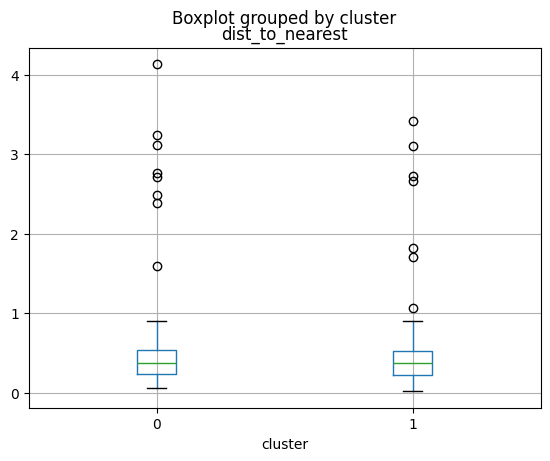

In [31]:
df_grouped.boxplot(['dist_to_nearest'], by='cluster')

Ya con el boxplot podemos ver que hay elementos que se alejan mucho de lo normal, así que vamos a detectarlos utilizando el criterio de la desviación estandar.

Aquellos elementos que se alejen más de 2 desviaciones estandar de lo que esperaríamos que se alejen normalmente, son anomalías: 

In [32]:
# Calculamos la desviación estandar por cada grupo. 
sd = df_grouped.groupby('cluster').std()['dist_to_nearest']
# Calculamos la mediana por cada grupo
median = df_grouped.groupby('cluster').median()['dist_to_nearest']

# Calculamos cual es la máxima distancia de los elementos al centroide, lo que cabríamos esperar

DESVIACIONES_ESTANDAR  = 2

tolerancia = median + DESVIACIONES_ESTANDAR*sd
tolerancia

cluster
0    1.751852
1    1.486527
Name: dist_to_nearest, dtype: float64

In [33]:
# definimos la función que va a determinar si cada fila tiene una distancia al centroide mayor a la tolerancia. En tal caso devuelve verdadero.
def is_outlier(row):
    return row['dist_to_nearest'] > tolerancia[row['cluster']]

# Aplicamos la función para cada linea.
df_grouped['is_outlier_clustering'] = df_grouped.apply(is_outlier,  axis=1)
df_grouped

,att1,att2,cluster,dist_to_nearest,is_outlier_clustering
0,2.149014,1.958521,1,0.203581,False
1,2.194307,2.456909,1,0.591458,False
2,1.929754,1.929759,1,0.022623,False
3,2.473764,2.230230,1,0.610009,False
4,1.859158,2.162768,1,0.260368,False
...,...,...,...,...,...
215,-2.983516,0.177946,0,2.386777,True
216,2.159948,-2.273432,0,4.132374,True
217,0.983124,-3.317220,0,3.234778,True
218,-3.586546,0.250837,0,2.759025,True


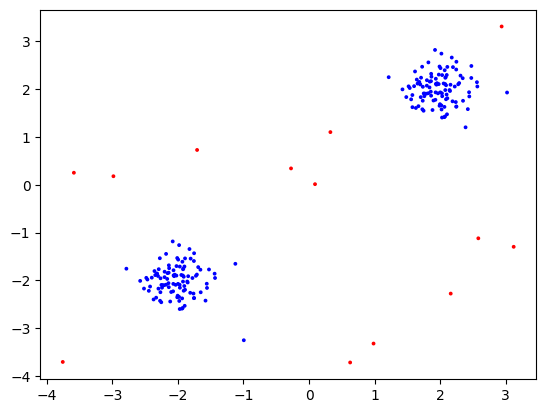

In [34]:
plt.scatter(df_grouped['att1'], df_grouped['att2'], c=df_grouped['is_outlier_clustering'], s=3.0, label="Puntos", cmap=ListedColormap(["blue","green","red"]))

Podemos hacer lo mismo con Local outlier factor ahora, pero este método ya te permite identificar las anomalías automáticamente, solo haciendo uso de la función fit_predict.

Veamos:

In [35]:
from sklearn.neighbors import LocalOutlierFactor

df_lof = df.copy()

lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
df_lof['is_outlier_lof'] = lof_model.fit_predict(df[['att1', 'att2']])

df_lof

,att1,att2,is_outlier_lof
0,2.149014,1.958521,1
1,2.194307,2.456909,1
2,1.929754,1.929759,1
3,2.473764,2.230230,1
4,1.859158,2.162768,1
...,...,...,...
215,-2.983516,0.177946,-1
216,2.159948,-2.273432,-1
217,0.983124,-3.317220,-1
218,-3.586546,0.250837,-1


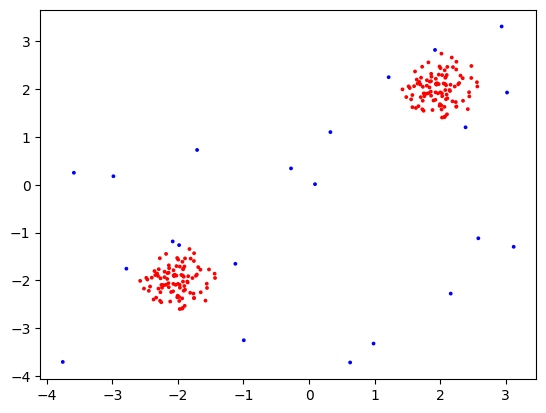

In [36]:
plt.scatter(df_lof['att1'], df_lof['att2'], c=df_lof['is_outlier_lof'], s=3.0, label="Puntos", cmap=ListedColormap(["blue","green","red"]))

En este caso se detectan más datos, ya que se utiliza la distancia relativa en cada vecindario, y no una medida tan general como en el caso de clustering.